# Google Cloud & NCAA® ML Competition 2018-Women's



## Abstract 
---
- This notebook consists of script for Google Cloud & NCAA® ML Competition 2018-Women's. The link to the competition page is https://www.kaggle.com/c/womens-machine-learning-competition-2018

## Author
---
Pawan Shivhare

In [45]:
import pandas as pd
import math
import os
import string
from sklearn.model_selection import KFold
import numpy as np
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

import seaborn as sns
sns.set_style("whitegrid")

matplotlib.style.use('ggplot')
# use the code below to make sure plot is shown in Notebook
%matplotlib inline 

os.chdir('/Users/pawanshivhare/Desktop/Kaggle Competition/basketball/WDataFiles')

from subprocess import check_output
print(check_output(["ls", "../WDataFiles"]).decode("utf8"))


WCities.csv
WGameCities.csv
WNCAATourneyCompactResults.csv
WNCAATourneySeeds.csv
WNCAATourneySlots.csv
WRegularSeasonCompactResults.csv
WSampleSubmissionStage1.csv
WSeasons.csv
WTeamSpellings.csv
WTeams.csv
ch1.csv
final.csv
sub1.csv



In [46]:
# Reading Tourney Seeds and Tourney Results

seeds = pd.read_csv('WNCAATourneySeeds.csv')
tour_results = pd.read_csv('WNCAATourneyCompactResults.csv')

print(seeds.head())
print(tour_results.head())

   Season Seed  TeamID
0    1998  W01    3330
1    1998  W02    3163
2    1998  W03    3112
3    1998  W04    3301
4    1998  W05    3272
   Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1998     137     3104      94     3422      46    H      0
1    1998     137     3112      75     3365      63    H      0
2    1998     137     3163      93     3193      52    H      0
3    1998     137     3198      59     3266      45    H      0
4    1998     137     3203      74     3208      72    A      0


In [47]:
# Pre Processing Tourney Results to make core of train dataset

def LLoc(x):
    if x=="H":return "A"
    elif x=="A":return "H"
    elif x=="N":return "N"


tour_results['LLoc']=[LLoc(x) for x in tour_results['WLoc']]
t1, t2 = train_test_split(tour_results, test_size=0.5,random_state=123)

t1=t1[["Season","WTeamID","LTeamID","WLoc"]].rename(columns={"WTeamID":"t1","WLoc":"t1_loc","LTeamID":"t2"})
t1["label"]=1

t2=t2[["Season","WTeamID","LTeamID","LLoc"]].rename(columns={"WTeamID":"t2","LLoc":"t1_loc","LTeamID":"t1"})
t2["label"]=0

full=pd.concat((t1,t2))
print(full.shape)


(1260, 5)


In [48]:
## In this section we will calculate performance variables (Overall Performance, Head to Head Performance, Specific 
## round performances)

# Pre Processing Regular season Results

tour_results = pd.read_csv('WRegularSeasonCompactResults.csv')

t1_rr=tour_results[["Season","WTeamID","WScore","LTeamID","LScore"]].rename(columns={
    "WTeamID":"t1","WScore":"t1_score","LTeamID":"t2","LScore":"t2_score"})
t1_rr["result"]=1

t2_rr=tour_results[["Season","WTeamID","WScore","LTeamID","LScore"]].rename(columns={
    "WTeamID":"t2","WScore":"t2_score","LTeamID":"t1","LScore":"t1_score"})
t2_rr["result"]=0

regular=pd.concat([t1_rr,t2_rr])

ch=regular[["Season","t1","result"]].groupby(["Season","t1"]).agg(['sum','count']).rename(columns={
    'sum':'wins_c_season','count':'total_games_c_season'})
ch.columns=ch.columns.droplevel()
ch['loss_c_season']=ch['total_games_c_season']-ch['wins_c_season']
ch=ch.reset_index()
print(ch.head())

ch2=regular[["Season","t1","t1_score"]].groupby(["Season","t1"]).agg(['mean']).rename(columns={
    'mean':'avg_score_c_season'})
ch2.columns=ch2.columns.droplevel()
ch2=ch2.reset_index()
print(ch2.head())


l1=seeds["Season"].unique()
ch1=pd.DataFrame()

for item in l1:
    x=item -2
    temp1=regular.loc[(regular["Season"]>x) & (regular["Season"]<=item)]
    temp2=temp1[["t1","result","t2"]].groupby(["t1","t2"]).agg(['sum','count']).rename(columns={
    'sum':'hh_wins_prev_2_season','count':'hh_total_games_prev_2_season'})
    temp2.columns=temp2.columns.droplevel()
    temp2['hh_loss_prev_2_season']=temp2['hh_total_games_prev_2_season']-temp2['hh_wins_prev_2_season']
    temp2["Season"]=item
    temp2=temp2.reset_index()
    ch1=pd.concat([ch1,temp2])    
print(ch1.head())



   Season    t1  wins_c_season  total_games_c_season  loss_c_season
0    1998  3102              4                    24             20
1    1998  3103             11                    29             18
2    1998  3104             21                    30              9
3    1998  3106              7                    23             16
4    1998  3108             13                    24             11
   Season    t1  avg_score_c_season
0    1998  3102           57.291667
1    1998  3103           69.241379
2    1998  3104           76.566667
3    1998  3106           61.130435
4    1998  3108           68.500000
     t1    t2  hh_wins_prev_2_season  hh_total_games_prev_2_season  \
0  3102  3119                      1                             1   
1  3102  3140                      0                             2   
2  3102  3161                      0                             2   
3  3102  3226                      0                             1   
4  3102  3286             

In [49]:
# Pre Processing championship Results

champ_results = pd.read_csv('WNCAATourneyCompactResults.csv')

t1_th=champ_results[["Season","WTeamID","WScore","LTeamID","LScore"]].rename(columns={
    "WTeamID":"t1","WScore":"t1_score","LTeamID":"t2","LScore":"t2_score"})
t1_th["result"]=1

t2_th=champ_results[["Season","WTeamID","WScore","LTeamID","LScore"]].rename(columns={
    "WTeamID":"t2","WScore":"t2_score","LTeamID":"t1","LScore":"t1_score"})
t2_th["result"]=0

champ=pd.concat([t1_th,t2_th])

th2=champ[["Season","t1","t1_score"]].groupby(["Season","t1"]).agg(['mean']).rename(columns={
    'mean':'avg_score_p1_tour'})
th2.columns=th2.columns.droplevel()
th2=th2.reset_index()
th2["Season"]=th2["Season"]+1

l1=seeds["Season"].unique()
th1=pd.DataFrame()
th=pd.DataFrame()

for item in l1:
    x=item -5
    temp1=champ.loc[(champ["Season"]>=x) & (champ["Season"]<=item-1)]
    
    temp2=temp1[["t1","result","t2"]].groupby(["t1","t2"]).agg(['sum','count']).rename(columns={
    'sum':'hh_wins_prev_5_tour','count':'hh_total_games_prev_5_tour'})
    temp2.columns=temp2.columns.droplevel()
    temp2['hh_loss_prev_5_tour']=temp2['hh_total_games_prev_5_tour']-temp2['hh_wins_prev_5_tour']
    temp2["Season"]=item
    temp2=temp2.reset_index()
    th1=pd.concat([th1,temp2])
    
    temp2=temp1[["t1","result"]].groupby(["t1"]).agg(['sum','count']).rename(columns={
    'sum':'wins_prev_5_tour','count':'total_games_prev_5_tour'})
    temp2.columns=temp2.columns.droplevel()
    temp2['loss_prev_5_tour']=temp2['total_games_prev_5_tour']-temp2['wins_prev_5_tour']
    temp2["Season"]=item
    temp2=temp2.reset_index()
    th=pd.concat([th,temp2])


ch_fin=pd.merge(left=ch,right=ch2,how='left',on=["Season","t1"])
ch_fin=pd.merge(left=ch_fin,right=th2,how='outer',on=["Season","t1"])
ch_fin=pd.merge(left=ch_fin,right=th,how='left',on=["Season","t1"])

ch1_fin=pd.merge(left=ch1,right=th1,how='outer',on=["Season","t1","t2"])


print(ch_fin.columns.values.tolist())
print(ch1_fin.columns.values.tolist())

['Season', 't1', 'wins_c_season', 'total_games_c_season', 'loss_c_season', 'avg_score_c_season', 'avg_score_p1_tour', 'wins_prev_5_tour', 'total_games_prev_5_tour', 'loss_prev_5_tour']
['t1', 't2', 'hh_wins_prev_2_season', 'hh_total_games_prev_2_season', 'hh_loss_prev_2_season', 'Season', 'hh_wins_prev_5_tour', 'hh_total_games_prev_5_tour', 'hh_loss_prev_5_tour']


In [50]:
# Pre processing the Seed Info

seeds['int_seed']=[int(x[1:3]) for x in seeds['Seed']]

l1=seeds["Season"].unique()
sh=pd.DataFrame()

for item in l1:
    x=item -4
    temp1=seeds.loc[(seeds["Season"]>=x) & (seeds["Season"]<=item)]
    temp2=temp1[["TeamID","int_seed"]].groupby(["TeamID"]).agg(['mean']).rename(columns={
    'mean':'avg_seed_prev_5'})
    temp2.columns=temp2.columns.droplevel()
    temp2["Season"]=item
    temp2=temp2.reset_index()
    sh=pd.concat([sh,temp2])    
print(sh.head())


   TeamID  avg_seed_prev_5  Season
0    3104              2.0    1998
1    3112              3.0    1998
2    3116              9.0    1998
3    3155              6.0    1998
4    3161             12.0    1998


In [51]:
#Merging Seeds Information 

t1_seeds=seeds[["Season","TeamID","int_seed"]].rename(columns={"TeamID":"t1","int_seed":"t1_c_seed"})
t2_seeds=seeds[["Season","TeamID","int_seed"]].rename(columns={"TeamID":"t2","int_seed":"t2_c_seed"})

temp=pd.merge(left=full,right=t1_seeds,how="left",on=["Season","t1"])
final=pd.merge(left=temp,right=t2_seeds,how="left",on=["Season","t2"])

# Merging P1 Seeds
t1_p1_seeds=seeds[["Season","TeamID","int_seed"]].rename(columns={"TeamID":"t1","int_seed":"t1_p1_seed"})
t2_p1_seeds=seeds[["Season","TeamID","int_seed"]].rename(columns={"TeamID":"t2","int_seed":"t2_p1_seed"})

t1_p1_seeds['Season']=t1_p1_seeds['Season']+1
t2_p1_seeds['Season']=t2_p1_seeds['Season']+1

final=pd.merge(left=final,right=t1_p1_seeds,how="left",on=["Season","t1"])
final=pd.merge(left=final,right=t2_p1_seeds,how="left",on=["Season","t2"])

# Calculating current and P1 seed differences

final['c_seed_diff']=final.t1_c_seed-final.t2_c_seed
final['p1_seed_diff']=final.t1_p1_seed-final.t2_p1_seed


final['t1_avg_seed_prev_5'] = \
    final[['Season','t1']].merge(sh,left_on = ['Season','t1'],
                                            right_on = ['Season','TeamID'],
                                             how='left')[['avg_seed_prev_5']]

final['t2_avg_seed_prev_5'] = \
    final[['Season','t2']].merge(sh,left_on = ['Season','t2'],
                                            right_on = ['Season','TeamID'],
                                             how='left')[['avg_seed_prev_5']]


# Joining all performance Information


t1=ch_fin.rename(columns={
    "wins_c_season":"t1_wins_c_season",
    "total_games_c_season":"t1_total_games_c_season",
'loss_c_season':'t1_loss_c_season',
'avg_score_c_season':'t1_avg_score_c_season'
, 'avg_score_p1_tour':'t1_avg_score_p1_tour', 
'wins_prev_5_tour':'t1_wins_prev_5_tour', 
'total_games_prev_5_tour':'t1_total_games_prev_5_tour', 
'loss_prev_5_tour':'t1_loss_prev_5_tour'
})

t2=ch_fin.rename(columns={"t1":"t2",
    "wins_c_season":"t2_wins_c_season",
    "total_games_c_season":"t2_total_games_c_season",
'loss_c_season':'t2_loss_c_season',
'avg_score_c_season':'t2_avg_score_c_season'
, 'avg_score_p1_tour':'t2_avg_score_p1_tour', 
'wins_prev_5_tour':'t2_wins_prev_5_tour', 
'total_games_prev_5_tour':'t2_total_games_prev_5_tour', 
'loss_prev_5_tour':'t2_loss_prev_5_tour'
})

final=pd.merge(left=final,right=t1,how="left",on=["Season","t1"])
final=pd.merge(left=final,right=t2,how="left",on=["Season","t2"])

t1=ch1_fin.rename(columns={
    "hh_wins_prev_2_season":"t1_hh_wins_prev_2_season",
    "hh_total_games_prev_2_season":"t1_hh_total_games_prev_2_season",
'hh_loss_prev_2_season':'t1_hh_loss_prev_2_season',
'hh_wins_prev_5_tour':'t1_hh_wins_prev_5_tour'
, 'hh_total_games_prev_5_tour':'t1_hh_total_games_prev_5_tour', 
'hh_loss_prev_5_tour':'t1_hh_loss_prev_5_tour'})


final=pd.merge(left=final,right=t1,how="left",on=["Season","t1","t2"])

final.head()

,Season,label,t1,t1_loc,t2,t1_c_seed,t2_c_seed,t1_p1_seed,t2_p1_seed,c_seed_diff,...,t2_avg_score_p1_tour,t2_wins_prev_5_tour,t2_total_games_prev_5_tour,t2_loss_prev_5_tour,t1_hh_wins_prev_2_season,t1_hh_total_games_prev_2_season,t1_hh_loss_prev_2_season,t1_hh_wins_prev_5_tour,t1_hh_total_games_prev_5_tour,t1_hh_loss_prev_5_tour
0,2001,1,3439,H,3176,7,10,NaN,NaN,-3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,1,3181,H,3116,1,9,2.0,NaN,-8,...,NaN,4.0,5.0,1.0,NaN,NaN,NaN,0.0,1.0,1.0
2,2015,1,3323,N,3390,1,4,1.0,2.0,-3,...,71.2,19.0,24.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2014,1,3124,N,3143,2,7,1.0,2.0,-5,...,73.4,7.0,10.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2001,1,3283,A,3353,5,4,10.0,2.0,1,...,64.6,9.0,12.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
# performance variables feature engineering

final['avg_seed_diff']=final.t1_avg_seed_prev_5-final.t2_avg_seed_prev_5
final['c_season_win_per_diff']=\
(final.t1_wins_c_season/final.t1_total_games_c_season)-(final.t2_wins_c_season/final.t2_total_games_c_season)
final['c_season_score_diff']=(final.t1_avg_score_c_season-final.t2_avg_score_c_season)
final['p1_tour_score_diff']=(final.t1_avg_score_p1_tour-final.t2_avg_score_p1_tour)

final['p1_tour_score_diff']=final['p1_tour_score_diff'].fillna(0)

final['wins_prev_5_tour_diff']=final['t1_wins_prev_5_tour'].fillna(0)-final['t2_wins_prev_5_tour'].fillna(0)
final['total_games_prev_5_tour_diff']=\
final['t1_total_games_prev_5_tour'].fillna(0)-final['t2_total_games_prev_5_tour'].fillna(0)


final['t1_hh_prev_2_season_win_rt']=final.t1_hh_wins_prev_2_season/final.t1_hh_total_games_prev_2_season
final['t1_hh_prev_2_season_win_rt']=final['t1_hh_prev_2_season_win_rt'].fillna(0)
final['t2_hh_prev_2_season_win_rt']=1-final.t1_hh_prev_2_season_win_rt


final['t1_hh_prev_5_tour_rt']=final.t1_hh_wins_prev_5_tour/final.t1_hh_total_games_prev_5_tour
final['t1_hh_prev_5_tour_rt']=final['t1_hh_prev_5_tour_rt'].fillna(0)
final['t2_hh_prev_5_tour_rt']=1-final.t1_hh_prev_5_tour_rt

final['avg_seed_diff']=np.where((final['avg_seed_diff']<=5)&(final['avg_seed_diff']>=-5),0,final['avg_seed_diff'])

In [53]:
# skill variables pre-procesing

os.chdir('/Users/pawanshivhare/Desktop/Kaggle Competition/basketball/skills')

from subprocess import check_output
print(check_output(["ls", "../skills"]).decode("utf8"))

3ptdef.csv
3ptfg.csv
assist_turnover.csv
blocked_shots.csv
field_goal.csv
field_goal_defense.csv
field_goal_ids.csv
final.csv
fouls.csv
free_throw.csv
rebound.csv
scoring.csv
skill.csv
steals.csv
turnover.csv



In [54]:
fg = pd.read_csv('field_goal.csv').drop(['W-L','Rank'],axis=1)
fg_def = pd.read_csv('field_goal_defense.csv').drop(['GM','W_L','Rank'],axis=1)
ft = pd.read_csv('free_throw.csv').drop(['GM','W-L','Rank'],axis=1)
fouls = pd.read_csv('fouls.csv')
fouls['DQPG']=fouls['DQ']/fouls['GM']
fouls=fouls.drop(['GM','W-L','Rank'],axis=1)
bks = pd.read_csv('blocked_shots.csv').drop(['GM','W-L','Rank'],axis=1)
to = pd.read_csv('assist_turnover.csv').drop(['GM','W-L','Rank'],axis=1)
pt3fg = pd.read_csv('3ptfg.csv').drop(['GM','W-L','Rank'],axis=1)
pt3fgdef = pd.read_csv('3ptdef.csv').drop(['GM','W_L','Rank'],axis=1)
rb = pd.read_csv('rebound.csv').drop(['GM','W-L','Rank'],axis=1)
sc = pd.read_csv('scoring.csv').drop(['GM','W-L','Rank'],axis=1)
st = pd.read_csv('steals.csv').drop(['GM','W-L','Rank'],axis=1)
to2 = pd.read_csv('turnover.csv').drop(['GM','W-L','Rank'],axis=1).rename(columns={'OPP TO':'OPP_TO',
                                                                                   'TO':'Turn','MAR':'Turn_Mar'})
ids = pd.read_csv('field_goal_ids.csv').drop(['Team'],axis=1)

skills=\
pd.merge(left=
pd.merge(left=
pd.merge(left=
pd.merge(left=
pd.merge(left=
pd.merge(left=
pd.merge(left=
pd.merge(left=
pd.merge(left=
pd.merge(left=
pd.merge(left=
pd.merge(left=fg,right=fg_def[['Season','Team','OPP_ FG', 'OPP_FGA','OPP_FG%']], 
                how='outer',on=['Season','Team']), 
                 right=ft,how='outer',on=['Season','Team']), 
                 right=fouls,how='outer',on=['Season','Team']), 
                 right=bks,how='outer',on=['Season','Team']), 
                 right=to,how='outer',on=['Season','Team']), 
                 right=pt3fg,how='outer',on=['Season','Team']), 
                 right=pt3fgdef,how='outer',on=['Season','Team']), 
                 right=rb,how='outer',on=['Season','Team']), 
                 right=sc,how='outer',on=['Season','Team']), 
                 right=st,how='outer',on=['Season','Team']), 
                 right=to2,how='outer',on=['Season','Team']), 
                 right=ids,how='left',right_on='Team Full',left_on='Team')

skills=skills.loc[(skills['Season']>2010)].drop(['Team Full','Team'],axis=1)

print(skills.head())

       GM     FGM     FGA   FG%  Season  OPP_ FG  OPP_FGA  OPP_FG%     FT  \
333  33.0   950.0  1895.0  50.1    2011    614.0   1911.0     32.1  467.0   
334  32.0  1111.0  2227.0  49.9    2011    725.0   1887.0     38.4  383.0   
335  31.0   919.0  1871.0  49.1    2011    618.0   1869.0     33.1  450.0   
336  33.0   942.0  1961.0  48.0    2011    663.0   1829.0     36.2  572.0   
337  33.0   932.0  1969.0  47.3    2011    655.0   2042.0     32.1  605.0   

       FTA   ...     PPG  OPPPTS  OPP_PPG  SCR_MAR     ST  STPG   Turn  \
333  607.0   ...    78.0  1649.0     50.0     27.7  302.0   9.2  506.0   
334  512.0   ...    86.0  1949.0     60.9     25.2  370.0  11.6  428.0   
335  603.0   ...    80.0  1701.0     54.9     25.1  229.0   7.4  441.0   
336  796.0   ...    78.0  1824.0     55.3     22.5  438.0  13.3  588.0   
337  814.0   ...    80.0  1772.0     53.7     26.4  263.0   8.0  462.0   

     OPP_TO  Turn_Mar      Id  
333   552.0      1.39  3163.0  
334   644.0      6.75  3211.

In [55]:
colnames=skills.columns.values.tolist()

excl=['OPP_ FG', 'OPP_FGA','OPP_FG%','PF','DQ','BLKS','OPP_3PT','OPP_3PTA','OPPREB', 'OPPREBPG','REB',
      'SCR_MAR','ST', 'OPP_TO','OPPPTS','3FG', '3FGA','Turn']
skills['FG_MAR']=skills['FG%']-skills['OPP_FG%']

retain=list(set(colnames)-set(excl))
print(retain)
skills=skills[retain]
skills.head()


['DQPG', 'TO', 'Ration', '3PTDEFPer', 'GM', 'FT', 'Turn_Mar', 'PFPG', 'PPG', 'FGA', 'AST', 'REBPG', 'PTS', '3FG%', 'FGM', 'Season', 'FTA', 'BKPG', 'STPG', 'FTP', 'REBMAR', 'Id', 'FG%', 'OPP_PPG']


,DQPG,TO,Ration,3PTDEFPer,GM,FT,Turn_Mar,PFPG,PPG,FGA,...,FGM,Season,FTA,BKPG,STPG,FTP,REBMAR,Id,FG%,OPP_PPG
333,0.151515,506.0,1.27,27.7,33.0,467.0,1.39,12.4,78.0,1895.0,...,950.0,2011,607.0,4.4,9.2,76.9,12.7,3163.0,50.1,50.0
334,0.156250,428.0,1.53,27.9,32.0,383.0,6.75,15.6,86.0,2227.0,...,1111.0,2011,512.0,3.7,11.6,74.8,8.3,3211.0,49.9,60.9
335,0.225806,441.0,1.24,27.8,31.0,450.0,1.29,14.8,80.0,1871.0,...,919.0,2011,603.0,3.5,7.4,74.6,11.5,3390.0,49.1,54.9
336,0.242424,588.0,0.97,26.1,33.0,572.0,5.15,16.7,78.0,1961.0,...,942.0,2011,796.0,4.5,13.3,71.9,9.1,3323.0,48.0,55.3
337,0.060606,462.0,1.21,26.0,33.0,605.0,2.52,13.1,80.0,1969.0,...,932.0,2011,814.0,7.1,8.0,74.3,10.6,3124.0,47.3,53.7


In [56]:
d1=dict()
for item in retain:
    if item=='Id': d1[item]='t1'
    elif item=='Season': continue
    else:
        d1[item]='t1_'+item
        
t1_skills=skills.rename(columns=d1)
t1_skills.head()

d2=dict()
for item in retain:
    if item=='Id': d2[item]='t2'
    elif item=='Season': continue
    else:
        d2[item]='t2_'+item

t2_skills=skills.rename(columns=d2)
t2_skills.head()


,t2_DQPG,t2_TO,t2_Ration,t2_3PTDEFPer,t2_GM,t2_FT,t2_Turn_Mar,t2_PFPG,t2_PPG,t2_FGA,...,t2_FGM,Season,t2_FTA,t2_BKPG,t2_STPG,t2_FTP,t2_REBMAR,t2,t2_FG%,t2_OPP_PPG
333,0.151515,506.0,1.27,27.7,33.0,467.0,1.39,12.4,78.0,1895.0,...,950.0,2011,607.0,4.4,9.2,76.9,12.7,3163.0,50.1,50.0
334,0.156250,428.0,1.53,27.9,32.0,383.0,6.75,15.6,86.0,2227.0,...,1111.0,2011,512.0,3.7,11.6,74.8,8.3,3211.0,49.9,60.9
335,0.225806,441.0,1.24,27.8,31.0,450.0,1.29,14.8,80.0,1871.0,...,919.0,2011,603.0,3.5,7.4,74.6,11.5,3390.0,49.1,54.9
336,0.242424,588.0,0.97,26.1,33.0,572.0,5.15,16.7,78.0,1961.0,...,942.0,2011,796.0,4.5,13.3,71.9,9.1,3323.0,48.0,55.3
337,0.060606,462.0,1.21,26.0,33.0,605.0,2.52,13.1,80.0,1969.0,...,932.0,2011,814.0,7.1,8.0,74.3,10.6,3124.0,47.3,53.7


In [57]:
final=pd.merge(left=final,right=t1_skills,how='left',on=["Season","t1"])
final=pd.merge(left=final,right=t2_skills,how='left',on=["Season","t2"])

In [58]:
final=final.loc[(final['Season']>=2011)]
final.to_csv('final.csv',index=False)

final['FGA_diff']=final['t1_FGA']-final['t2_FGA']
final['DQPG_diff']=final['t1_DQPG']-final['t2_DQPG']
final['FTP_diff']=final['t1_FTP']-final['t2_FTP']
final['3FG%_diff']=final['t1_3FG%']-final['t2_3FG%']
final['3PTDEFPer_diff']=final['t1_3PTDEFPer']-final['t2_3PTDEFPer']
final['FTA_diff']=final['t1_FTA']-final['t2_FTA']
final['FGM_diff']=final['t1_FGM']-final['t2_FGM']
final['STPG_diff']=final['t1_STPG']-final['t2_STPG']
final['BKPG_diff']=final['t1_BKPG']-final['t2_BKPG']
final['OPP_PPG_diff']=final['t1_OPP_PPG']-final['t2_OPP_PPG']
final['PPG_diff']=final['t1_PPG']-final['t2_PPG']
final['REBPG_diff']=final['t1_REBPG']-final['t2_REBPG']
final['FT_diff']=final['t1_FT']-final['t2_FT']
final['AST_diff']=final['t1_AST']-final['t2_AST']
final['Ration_diff']=final['t1_Ration']-final['t2_Ration']
#final['PTS_diff']=final['t1_PTS']-final['t2_PTS']
final['TO_diff']=final['t1_TO']-final['t2_TO']
final['PFPG_diff']=final['t1_PFPG']-final['t2_PFPG']
final['REBMAR_diff']=final['t1_REBMAR']-final['t2_REBMAR']
final['Turn_Mar_diff']=final['t1_Turn_Mar']-final['t2_Turn_Mar']
final['FG%_diff']=final['t1_FG%']-final['t2_FG%']


In [59]:
colnames=final.columns.values.tolist()

excl=['Season', 't1', 't2','t1_loc','t1_c_seed', 't2_c_seed', 't1_p1_seed','t1_total_games_prev_5_tour',
      't2_p1_seed', 'p1_seed_diff', 't1_avg_seed_prev_5', 't2_avg_seed_prev_5', 't2_total_games_prev_5_tour',
      't1_wins_c_season', 't1_total_games_c_season', 't1_loss_c_season', 't1_avg_score_c_season', 
      't1_avg_score_p1_tour', 't1_loss_prev_5_tour', 'c_seed_diff','t1_wins_prev_5_tour','t2_wins_prev_5_tour',
      't2_wins_c_season', 't2_total_games_c_season', 't2_loss_c_season', 't2_avg_score_c_season', 
      't2_avg_score_p1_tour','t2_loss_prev_5_tour', 't1_hh_wins_prev_2_season', 't1_hh_total_games_prev_2_season', 
      't1_hh_loss_prev_2_season', 't1_hh_wins_prev_5_tour', 't1_hh_total_games_prev_5_tour', 't1_hh_loss_prev_5_tour',
     't2_hh_prev_5_tour_rt', 't1_hh_prev_5_tour_rt', 't1_hh_prev_2_season_win_rt','t2_hh_prev_2_season_win_rt',
     'p1_tour_score_diff',
     
     't1_FGA','t1_DQPG','t1_FTP','t1_3FG%','t1_3PTDEFPer','t1_FTA','t1_FGM','t1_STPG','t1_BKPG','t1_OPP_PPG',
't1_PPG','t1_REBPG','t1_FT','t1_AST','t1_Ration','t1_PTS','t1_TO','t1_PFPG','t1_REBMAR','t1_Turn_Mar',
       't2_FGA','t2_DQPG','t2_FTP','t2_3FG%','t2_3PTDEFPer','t2_FTA','t2_FGM','t2_STPG','t2_BKPG','t2_OPP_PPG',
't2_PPG','t2_REBPG','t2_FT','t2_AST','t2_Ration','t2_PTS','t2_TO','t2_PFPG','t2_REBMAR','t2_Turn_Mar',
     't2_GM','t1_GM','t1_PTS','t2_pts','t1_FG%','t2_FG%',
     
      'avg_seed_diff',
 'wins_prev_5_tour_diff',
 'total_games_prev_5_tour_diff',]

retain=list(set(colnames)-set(excl))
print(retain)

final=final[retain]

final.head()

['label', '3PTDEFPer_diff', 'REBMAR_diff', 'PPG_diff', 'BKPG_diff', 'TO_diff', 'REBPG_diff', 'FTA_diff', 'c_season_score_diff', 'OPP_PPG_diff', 'FG%_diff', 'DQPG_diff', 'STPG_diff', '3FG%_diff', 'FTP_diff', 'FGA_diff', 'PFPG_diff', 'FGM_diff', 'c_season_win_per_diff', 'Ration_diff', 'Turn_Mar_diff', 'AST_diff', 'FT_diff']


,label,3PTDEFPer_diff,REBMAR_diff,PPG_diff,BKPG_diff,TO_diff,REBPG_diff,FTA_diff,c_season_score_diff,OPP_PPG_diff,...,3FG%_diff,FTP_diff,FGA_diff,PFPG_diff,FGM_diff,c_season_win_per_diff,Ration_diff,Turn_Mar_diff,AST_diff,FT_diff
2,1,-3.5,6.2,12.0,0.4,98.0,2.0,132.0,12.303030,0.0,...,0.1,3.2,109.0,-0.7,175.0,0.212121,0.36,2.34,262.0,117.0
3,1,-3.0,5.6,14.0,1.3,-39.0,4.0,88.0,13.600000,-4.0,...,5.7,6.7,372.0,0.6,247.0,0.178788,0.66,5.69,239.0,112.0
5,1,5.2,1.8,-1.0,-0.5,-49.0,-1.0,-73.0,-1.486096,4.4,...,-0.1,1.4,27.0,-0.3,67.0,0.011123,0.25,-2.37,71.0,-44.0
8,1,3.4,-0.1,21.0,0.0,-113.0,-3.0,-7.0,20.718750,-3.4,...,0.3,6.2,284.0,-2.8,304.0,0.125000,0.82,14.15,200.0,23.0
12,1,-2.0,9.4,9.0,0.6,9.0,5.0,236.0,8.231250,-5.8,...,0.3,1.6,127.0,1.1,133.0,0.368750,0.02,-0.14,19.0,167.0


In [60]:
final=final.dropna()

final.to_csv('final.csv',index=False)

['label', '3PTDEFPer_diff', 'REBMAR_diff', 'PPG_diff', 'BKPG_diff', 'TO_diff', 'REBPG_diff', 'FTA_diff', 'c_season_score_diff', 'total_games_prev_5_tour_diff', 'OPP_PPG_diff', 'avg_seed_diff', 'FG%_diff', 'DQPG_diff', 'STPG_diff', '3FG%_diff', 'FTP_diff', 'wins_prev_5_tour_diff', 'FGA_diff', 'PFPG_diff', 'FGM_diff', 'c_season_win_per_diff', 'Ration_diff', 'Turn_Mar_diff', 'AST_diff', 'FT_diff']
['label', '3PTDEFPer_diff', 'REBMAR_diff', 'PPG_diff', 'BKPG_diff', 'TO_diff', 'REBPG_diff', 'FTA_diff', 'c_season_score_diff', 'total_games_prev_5_tour_diff', 'OPP_PPG_diff', 'avg_seed_diff', 'FG%_diff', 'DQPG_diff', 'STPG_diff', '3FG%_diff', 'wins_prev_5_tour_diff', 'FTP_diff', 'FGA_diff', 'PFPG_diff', 'FGM_diff', 'c_season_win_per_diff', 'Ration_diff', 'Turn_Mar_diff', 'AST_diff', 'FT_diff']


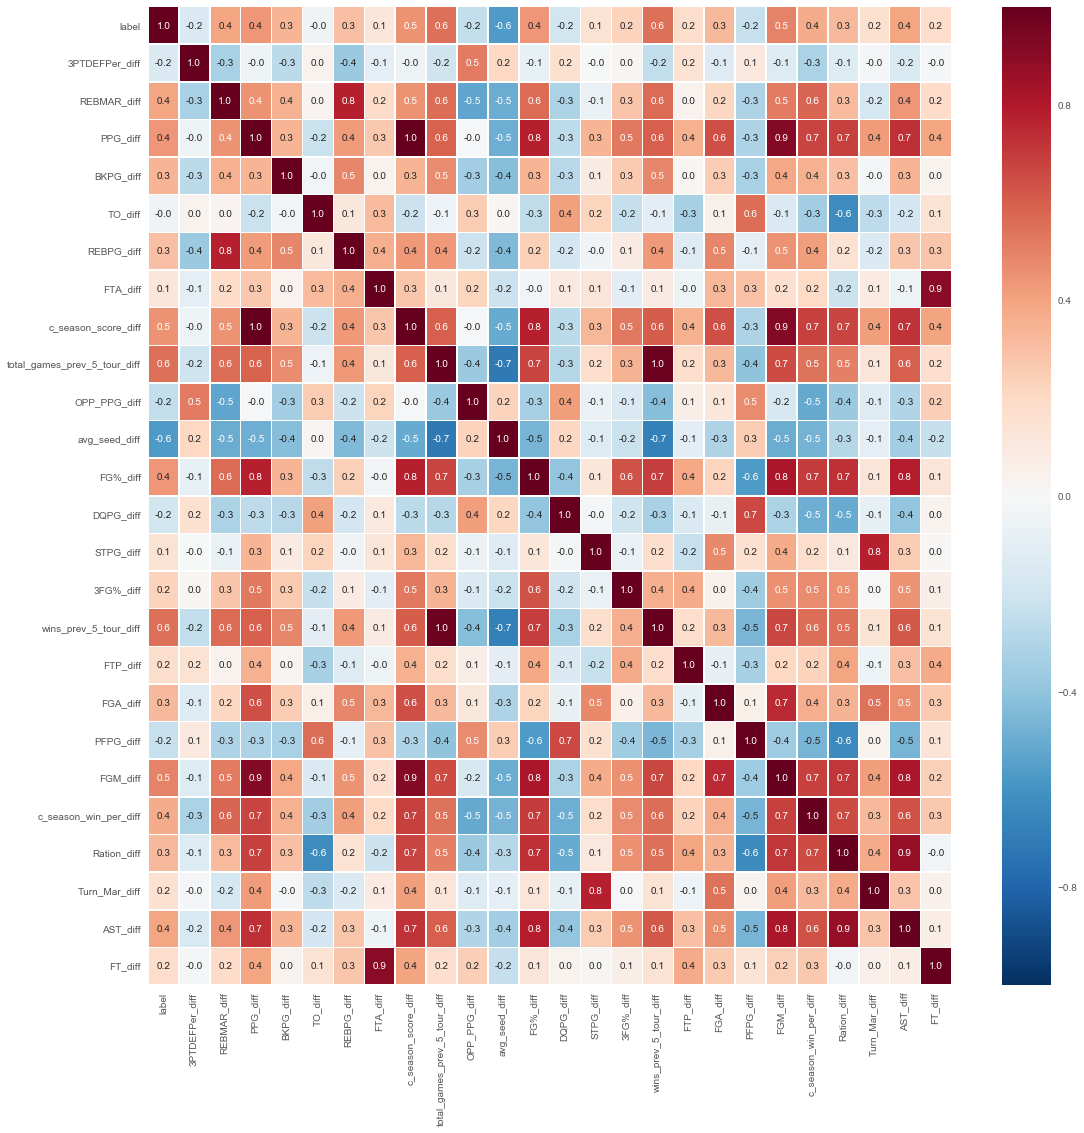

In [17]:
#Some Visualization

colnames=final.columns.values.tolist()
print(colnames)

excl=['Season', 't1', 't2']

retain=list(set(colnames)-set(excl))
print(retain)

final=final[retain]
final.head()

corrset=final._get_numeric_data().columns.values.tolist()
           
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(final[corrset].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)


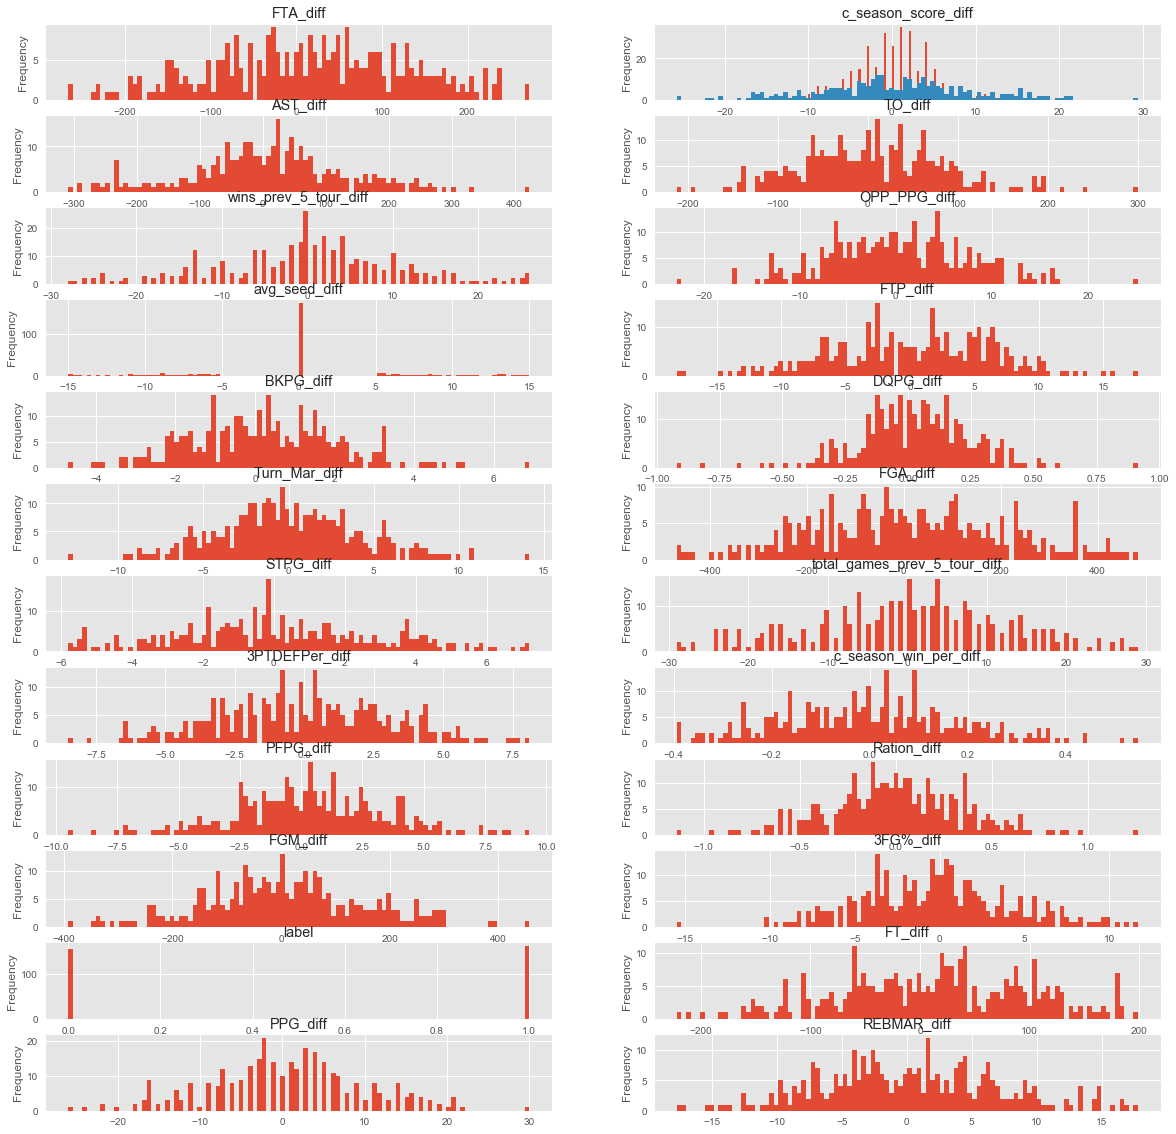

In [320]:
# Lets check the distribution of the variables and relationship with the target variable

fig, axes = plt.subplots(nrows=round(len(corrset)/2), ncols=2,figsize=(20,20))
i=0
j=0
for item in corrset:
    final[item].plot.hist(ax=axes[i,j],bins=100); axes[i,j].set_title(item);
    if i == round(len(corrset)/2)-1: 
        i=0
        j=1
    else: i=i+1

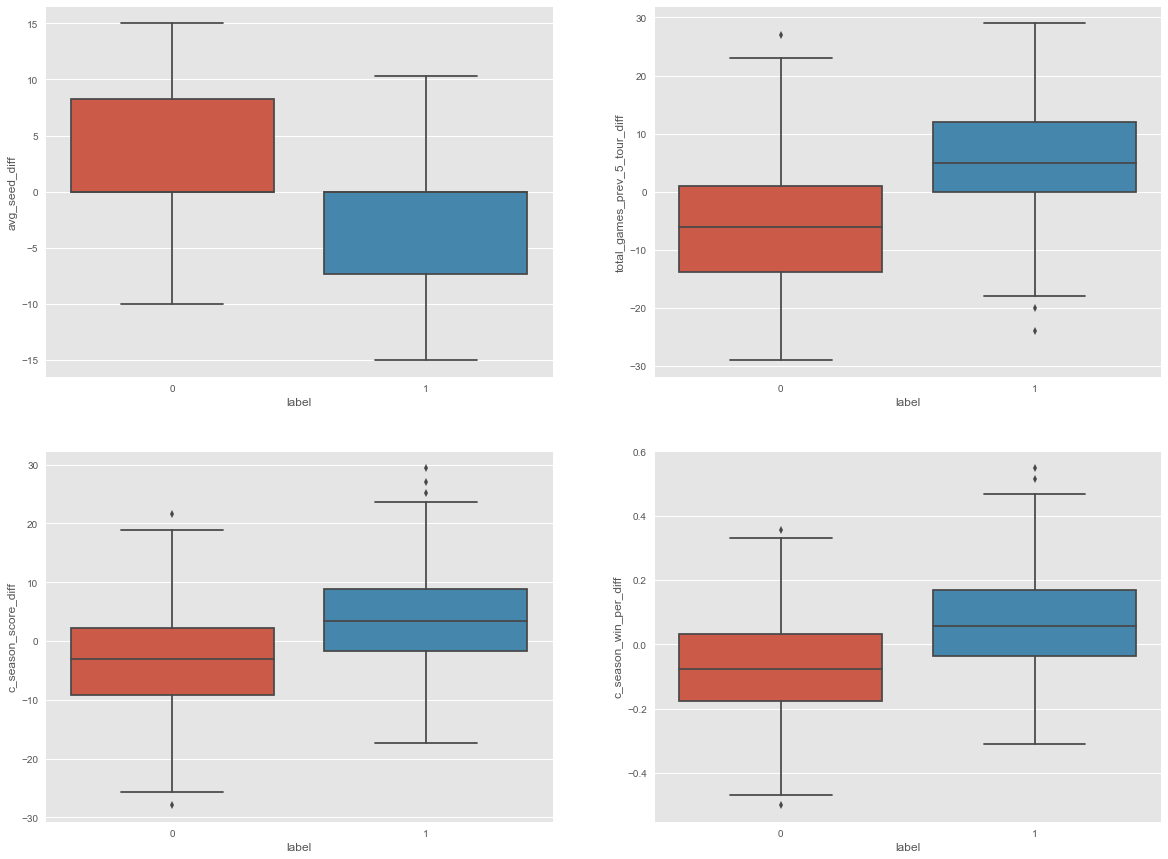

In [165]:
# Define a function for a bar plot

def barplot(df, x , y, title, p , q):
    l=[x,y]
    means = df[l].groupby(x).agg([np.mean, np.std])
    means.columns = means.columns.droplevel()
    means['mean'].plot.bar(title=title,ax=axes[p,q]) 
    
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,15))
sns.boxplot(x="label", y="avg_seed_diff", data=final,ax=axes[0,0])
sns.boxplot(x="label", y="c_season_score_diff", data=final,ax=axes[1,0])
sns.boxplot(x="label", y="c_season_win_per_diff", data=final,ax=axes[1,1])
sns.boxplot(x="label", y="total_games_prev_5_tour_diff", data=final,ax=axes[0,1])


In [166]:
# Need to create dummy Values 

#dummies=pd.get_dummies(final['t1_loc'],prefix='t1_loc')
#final=pd.concat([final,dummies],axis=1)

#def NLoc(x):
 #   if x=="H":return 1
  #  elif x=="A":return -1
   # elif x=="N":return 0

#final['NLoc']=[NLoc(x) for x in final['t1_loc']]
#print(final.head())

#colnames=final.columns.values.tolist()
#excl=['t1_loc','seed_diff']

#retain=list(set(colnames)-set(excl))
#print(retain)

#final=final[retain]

#print(final.isnull().sum())

## Method 2 

# Feature selection: 




In [40]:
label=['label']
train_features=list(set(final.columns.values.tolist()) - set(label))

# Split data in test and train

X_train, X_test, y_train, y_test = train_test_split(final[train_features], final[label]
                                                    , test_size=0.3, random_state=123)

In [41]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train,y_train)

d1=dict()
cols=X_train.columns.values.tolist()
imp=list(model.feature_importances_)
for i in range(len(cols)):
    d1[cols[i]]=imp[i]
d1

{'3FG%_diff': 0.034037140407095288,
 '3PTDEFPer_diff': 0.033801484179050656,
 'AST_diff': 0.033999314615937387,
 'BKPG_diff': 0.062712246470179145,
 'DQPG_diff': 0.029957462453147565,
 'FG%_diff': 0.062973632816722497,
 'FGA_diff': 0.057682850364175774,
 'FGM_diff': 0.077415220646811209,
 'FTA_diff': 0.039606546015149333,
 'FTP_diff': 0.038583745726002996,
 'FT_diff': 0.041995155425155958,
 'OPP_PPG_diff': 0.036343476053523893,
 'PFPG_diff': 0.034816759351778512,
 'PPG_diff': 0.07048358141413523,
 'REBMAR_diff': 0.048982397140834175,
 'REBPG_diff': 0.046387329652621698,
 'Ration_diff': 0.035064423116396307,
 'STPG_diff': 0.03816251218785794,
 'TO_diff': 0.032399385222048063,
 'Turn_Mar_diff': 0.025665080701764365,
 'c_season_score_diff': 0.065086484871666822,
 'c_season_win_per_diff': 0.053843771167945163}

In [42]:
selected_feat=[  'FGM_diff',
 'PPG_diff',
 'FG%_diff',
 'BKPG_diff',
 'c_season_win_per_diff',
 'REBMAR_diff',
 'FT_diff'
]

X_train1=X_train
X_train=X_train1[selected_feat]
X_test1=X_test
X_test=X_test1[selected_feat]

In [43]:
# Method 1 - Building model with all features - Logistic


#***********************************K fold cross validation with different values of K as 5 *******#

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 

kfold = KFold(n_splits= 5, random_state= 123)
result = cross_val_score(LogisticRegression(), X_train, y_train, cv=kfold, scoring='neg_log_loss')

print("LL:", result)
print("Mean LL:", result.mean())
print("Median LL:", np.median(result))

# The mean and median of accuracy on test is almost same indicating the model is not overfitting #

#*********************************** Fit a logistic model on full train data ****************#

logreg = LogisticRegression()
model = logreg.fit(X_train,y_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


train_pred=model.predict(X_train)
train_accu=accuracy_score(y_train,train_pred)
train_auc=roc_auc_score(y_train,train_pred)

print("Train Accuracy: ", train_accu)
print("Train AUC: ", train_auc)
print(classification_report(y_train,train_pred))

test_pred=model.predict(X_test)
test_accu=accuracy_score(y_test,test_pred)
test_auc=roc_auc_score(y_test,test_pred)
print("Test Accuracy: ",test_accu)
print("Test AUC: ", test_auc)
print(classification_report(y_test,test_pred))


LL: [-0.47884527 -0.56709368 -0.74406089 -0.44738301 -0.53043483]
Mean LL: -0.553563534996
Median LL: -0.530434834215
Train Accuracy:  0.745535714286
Train AUC:  0.745472676506
             precision    recall  f1-score   support

          0       0.74      0.74      0.74       109
          1       0.75      0.75      0.75       115

avg / total       0.75      0.75      0.75       224

Test Accuracy:  0.729166666667
Test AUC:  0.729166666667
             precision    recall  f1-score   support

          0       0.72      0.75      0.73        48
          1       0.74      0.71      0.72        48

avg / total       0.73      0.73      0.73        96



In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score 

kfold = KFold(n_splits= 5, random_state= 123)
result = cross_val_score(RandomForestClassifier(max_features=6,max_depth=6),
                         X_train, y_train, cv=kfold, scoring='neg_log_loss')

print("Accuracy:", result)
print("Mean Accuracy:", result.mean())
print("Median Accuracy:", np.median(result))

# The mean and median of accuracy on test is almost same indicating the model is not overfitting #

#*********************************** Fit a RandomForest model on full train data ****************#

rfmodel = RandomForestClassifier(max_features=6,max_depth=6)
model = rfmodel.fit(X_train,y_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


train_pred=model.predict(X_train)
train_accu=accuracy_score(y_train,train_pred)
train_auc=roc_auc_score(y_train,train_pred)

print("Train Accuracy: ", train_accu)
print("Train AUC: ", train_auc)
print(classification_report(y_train,train_pred))

test_pred=model.predict(X_test)
test_accu=accuracy_score(y_test,test_pred)
test_auc=roc_auc_score(y_test,test_pred)
print("Test Accuracy: ",test_accu)
print("Test AUC: ", test_auc)
print(classification_report(y_test,test_pred))

Accuracy: [-1.97830246 -1.34320507 -1.59769043 -0.50383658 -0.55453419]
Mean Accuracy: -1.19551374407
Median Accuracy: -1.34320507118
Train Accuracy:  0.96875
Train AUC:  0.967889908257
             precision    recall  f1-score   support

          0       1.00      0.94      0.97       109
          1       0.94      1.00      0.97       115

avg / total       0.97      0.97      0.97       224

Test Accuracy:  0.614583333333
Test AUC:  0.614583333333
             precision    recall  f1-score   support

          0       0.63      0.54      0.58        48
          1       0.60      0.69      0.64        48

avg / total       0.62      0.61      0.61        96



In [ ]:
from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

In [ ]:
sample = pd.read_csv('WSampleSubmissionStage1.csv')

sample=sample.drop(["Pred"],axis=1)
sample['Season']=[int(x.split('_')[0]) for x in sample['ID']]
sample['t1']=[int(x.split('_')[1]) for x in sample['ID']]
sample['t2']=[int(x.split('_')[2]) for x in sample['ID']]

t1_seeds=seeds[["Season","TeamID","int_seed"]].rename(columns={"TeamID":"t1","int_seed":"t1_seed"})
t2_seeds=seeds[["Season","TeamID","int_seed"]].rename(columns={"TeamID":"t2","int_seed":"t2_seed"})

temp=pd.merge(left=sample,right=t1_seeds,how="left",on=["Season","t1"])
samp=pd.merge(left=temp,right=t2_seeds,how="left",on=["Season","t2"])

samp['seed_diff']=samp.t1_seed-samp.t2_seed


In [ ]:
def LLoc(x):
    if x=="H":return "A"
    elif x=="A":return "H"
    elif x=="N":return "N"

tour_results['LLoc']=[LLoc(x) for x in tour_results['WLoc']]

t1=tour_results[["Season","WTeamID","LTeamID","WLoc"]].rename(columns={"WTeamID":"t1","WLoc":"t1_loc","LTeamID":"t2"})
t2=tour_results[["Season","WTeamID","LTeamID","LLoc"]].rename(columns={"WTeamID":"t2","LLoc":"t1_loc","LTeamID":"t1"})

full=pd.concat((t1,t2))

samp=pd.merge(left=samp,right=full,how="left",on=["Season","t2","t1"])
samp['t1_loc']=np.where(samp['t1_loc'].isnull(),'N',samp['t1_loc'])

def NLoc(x):
    if x=="H":return 1
    elif x=="A":return -1
    elif x=="N":return 0

samp['NLoc']=[NLoc(x) for x in samp['t1_loc']]

print(samp.head())

In [ ]:
preds = model.predict_proba(samp[["t1_seed","t2_seed","NLoc"]])[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
samp["Pred"] = clipped_preds
samp.head()

In [ ]:
samp.to_csv('sub1.csv', index=False)